## Import Libraries

In [8]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [77]:
import pickle
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, FreqDist

## Load Dataframe

In [3]:
df = pd.read_pickle('cleaned_tweets')

In [4]:
df.head()

,Unnamed: 0,Mobile Network,Tweet Created At,Tweet Text,Cleaned Tweets
0,0,@VodafoneUK,2019-12-04 08:05:14,@VodafoneUK Plus £2.28 package &amp; posting !...,"[plus, £2.28, package, posting]"
1,1,@VodafoneUK,2019-12-04 08:04:05,I have repeatedly asked how to get a refund so...,"[repeatedly, asked, get, refund, use, another,..."
2,2,@VodafoneUK,2019-12-04 08:01:19,"I have supplied visa details twice, I have bee...","[supplied, visa, detail, twice, subjected, hor..."
3,3,@VodafoneUK,2019-12-04 07:57:42,@VodafoneIN promised yesterday I’d receive no ...,"[promised, yesterday, receive, call, would, ge..."
4,4,@VodafoneUK,2019-12-04 07:57:16,@VodafoneUK you send texts about rewards - thi...,"[send, text, reward, morning, lindt, take, app..."


## Word Cloud

In [69]:
## Create combined string with all words

vodafone_combined_string = ''

for tweet in df.loc[df['Mobile Network']=="@VodafoneUK"]['Cleaned Tweets']: 
    
    for word in tweet:
        
        vodafone_combined_string = vodafone_combined_string + ' ' + word
    

In [70]:
vodafone_combined_string

" plus £2.28 package posting repeatedly asked get refund use another provider also asked escalate complaint refuse give information supplied visa detail twice subjected horrendously rude staff instore vodafone stealing money removing service paid tourist use vodafone promised yesterday receive call would get email 30 min email received today received yet another call vodaphone incompetence mean losing data paid midnight send text reward morning lindt take app never matter quickly look actually becomes annoying hi e-gift card wondering also use 2 1 gift card world without limit feel like world without coverage 🤦\u200d♂️ impossible get reliable voice data connection mainline route london waterloo signal poor 2019 1992 😶 knew know would stayed ironically suggested move provider completion date repair mast 😖😖 annoyed 😡😡 reply /tlmdswvnna still waiting resolution issue still present today think may problem end check phone set 3g getting incredible 4g speed london using vodafone 100mbps plus

In [71]:
wordcloud = WordCloud().generate(vodafone_combined_string)

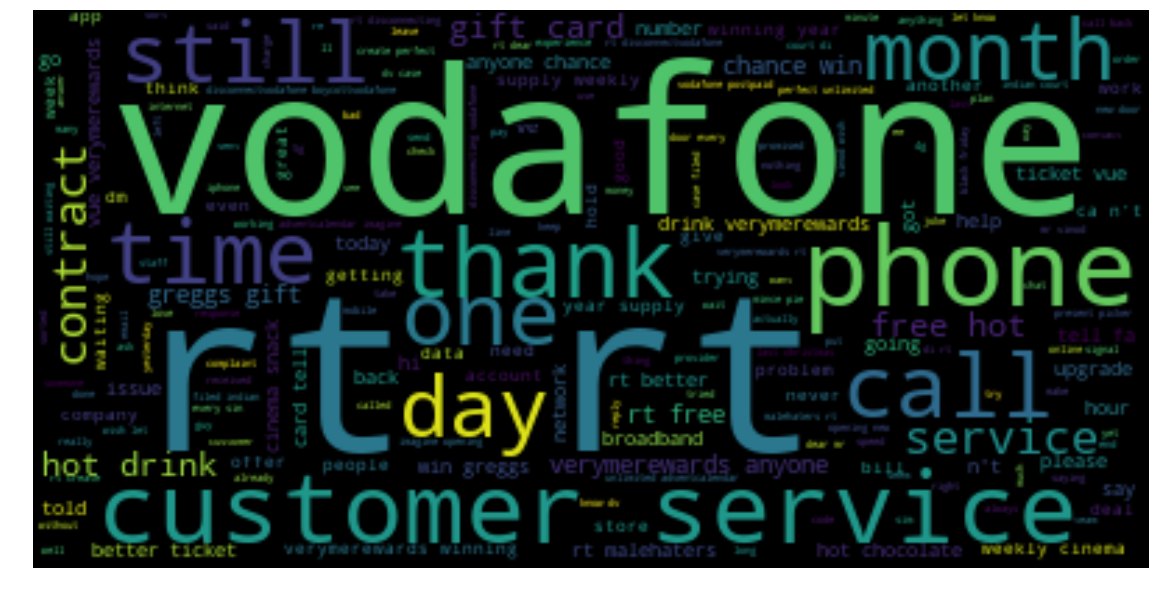

In [72]:
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Frequency Distributions

In [81]:
vodafone_combined = []

for tweet in df.loc[df['Mobile Network']=="@ThreeUK"]['Cleaned Tweets']:
    vodafone_combined += tweet
    


In [82]:
articles_freqdist = FreqDist(vodafone_combined)
articles_freqdist.most_common(200)

[('rt', 835),
 ('network', 719),
 ('5g', 476),
 ('get', 442),
 ('uk', 433),
 ('phone', 430),
 ('customer', 417),
 ('service', 399),
 ('three', 375),
 ('partner', 374),
 ("n't", 374),
 ('reliable', 372),
 ('action', 366),
 ('hardly', 363),
 ('ethic', 361),
 ('of…', 359),
 ('stop', 348),
 ("'s", 334),
 ('call', 279),
 ('contract', 262),
 ('data', 239),
 ('signal', 221),
 ('time', 213),
 ('new', 209),
 ('month', 207),
 ('like', 196),
 ("'ve", 188),
 ('day', 181),
 ('4g', 169),
 ('one', 167),
 ('number', 167),
 ('year', 166),
 ('still', 156),
 ('3', 156),
 ('even', 154),
 ('work', 153),
 ('back', 153),
 ('deal', 152),
 ('know', 148),
 ('issue', 146),
 ('going', 146),
 ('getting', 142),
 ('please', 141),
 ('company', 136),
 ('would', 135),
 ('got', 135),
 ('go', 133),
 ("'m", 131),
 ('use', 129),
 ('never', 120),
 ('ca', 115),
 ('good', 114),
 ('problem', 114),
 ('wuntu', 114),
 ('money', 113),
 ('sim', 112),
 ('bill', 108),
 ('want', 107),
 ('need', 107),
 ('take', 104),
 ('mobile', 104),
